In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import sys
import os

%matplotlib inline

In [2]:
county_data = pd.read_csv(os.path.realpath("./Data/us_county.csv"))
covid_county_data = pd.read_csv(os.path.realpath("./Data/covid_us_county.csv")).filter(items=["county","state_code","lat","long",
                                                                                                 "date","cases"])
county_pop = pd.read_csv(os.path.realpath("./Data/us_county.csv"))
county_pop = county_pop.sort_values(by="population")

In [3]:
# load in the data
covid_county_data = covid_county_data[(covid_county_data["date"] <= "2020-12-31")]
print(covid_county_data.shape)
covid_county_data.head(5)

(1152990, 6)


,county,state_code,lat,long,date,cases
0,Autauga,AL,32.539527,-86.644082,2020-01-22,0
1,Autauga,AL,32.539527,-86.644082,2020-01-23,0
2,Autauga,AL,32.539527,-86.644082,2020-01-24,0
3,Autauga,AL,32.539527,-86.644082,2020-01-25,0
4,Autauga,AL,32.539527,-86.644082,2020-01-26,0


# Explain the data
# Discuss some basic findings (first cases date distribution, total case counts distribution, case count proportions by county, correlation between case proportion size and population size?)

In [4]:
np.random.seed(101)

#choose 20 counties to look at, can we find the best parameters for predicting their spread
county_index = list(sts.randint.rvs(low=1,high=county_pop.shape[0]-2,size=19)) + [county_pop.shape[0]-1]
county_index.sort()
counties_to_investigate = county_pop.iloc[county_index,:]
counties_to_investigate

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
261,8033,Dolores County,Colorado,CO,989,852,51.8,1841,46.279196,37.751712,-108.517400
2531,48017,Bailey County,Texas,TX,3640,3452,33.5,7092,48.674563,34.068578,-102.829874
2690,48335,Mitchell County,Texas,TX,5383,3175,34.1,8558,37.099790,32.306202,-100.921138
1569,29173,Ralls County,Missouri,MO,5178,5039,45.0,10217,49.319761,39.527685,-91.522031
1023,21061,Edmonson County,Kentucky,KY,6093,6029,43.8,12122,49.736017,37.208799,-86.238422
398,13023,Bleckley County,Georgia,GA,5937,6838,36.8,12775,53.526419,32.434445,-83.327814
1593,29223,Wayne County,Missouri,MO,6544,6764,47.3,13308,50.826570,37.112647,-90.461405
2133,40005,Atoka County,Oklahoma,OK,7306,6568,40.6,13874,47.340349,34.373729,-96.037824
770,18147,Spencer County,Indiana,IN,10363,10163,43.6,20526,49.512813,38.014096,-87.007670
3040,54097,Upshur County,West Virginia,WV,12200,12405,42.0,24605,50.416582,38.897844,-80.233441


In [5]:
def q_split(cty):
    return str(cty).rsplit()[0]

counties_to_investigate["county"] = counties_to_investigate.county.apply(q_split)
counties_to_investigate.iloc[19,1] = "Los Angeles"

<ipython-input-5-95a4866d2212>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counties_to_investigate["county"] = counties_to_investigate.county.apply(q_split)
C:\Users\564207\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [6]:
#first need function to calc diff only if condition met

def ret_bool(cell):
    
    if cell < 0:
        return(0)
    else:
        return(cell)
    
## inner join investigate with daily cases data to filter on counties of interest
counties_filter = counties_to_investigate.merge(covid_county_data,on=["county","state_code"]).iloc[:,[1,2,7,13,14]]
counties_filter["daily_diff"] = [0]+list(np.array(counties_filter.cases[1:counties_filter.shape[0]])-np.array(counties_filter.cases[0:(counties_filter.shape[0]-1)]))

#find the first day with more than 1 case across all cities
cases_temp = pd.Series(counties_filter.sort_values("date").reset_index().cases > 0)
cases_temp = cases_temp[cases_temp].index[0]

#date at that point
date_start = counties_filter.sort_values("date").date.iloc[cases_temp]

#filter from that point on
counties_filter = counties_filter.sort_values("date").reset_index()
counties_filter = counties_filter[counties_filter.date >= date_start]
counties_filter = counties_filter.sort_values(by=["county","date"]).reset_index().iloc[:,[2,3,5,6,7]]

#deal with new cities every once in awhile
counties_filter["daily_diff"] = counties_filter["daily_diff"].apply(ret_bool)

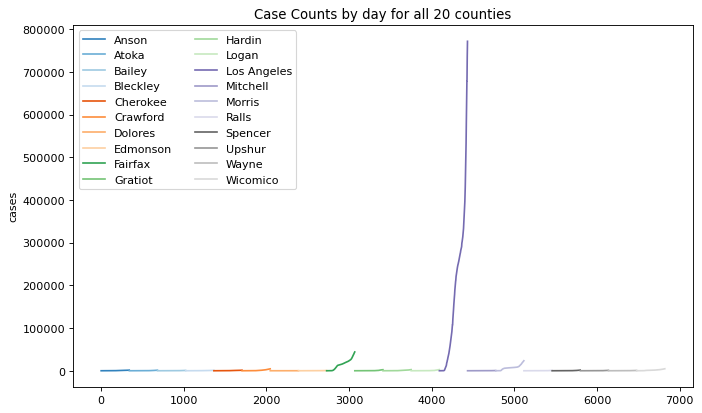

In [7]:
### make some plots, first we can look at the time series of cases for each county

from matplotlib.pyplot import figure
#for each county, filter df and add a line plot. loop through the colormap too to assign colors to each line
#need to creat the ax, fig objects to add the line plots to
figure(figsize=(10, 6), dpi=80)
case_plot = sns.lineplot(data=counties_filter,hue="county",palette="tab20c",x=range(0,counties_filter.shape[0]),y="cases",
                        legend=True)
plt.title("Case Counts by day for all 20 counties")
plt.legend(loc="upper left",ncol=2)

# CHANGE THE BELOW FIGURE TO HISTOGRAMS FOR EACH COUNTY

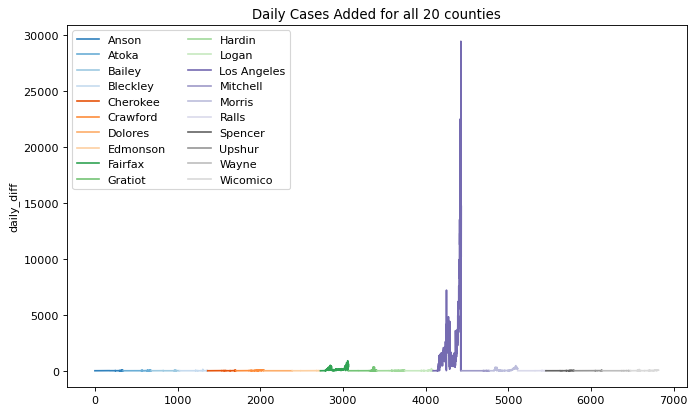

In [8]:
## create ax and figure object and add each dataset to the plot one-by-one.
## index should hopefully be the same for each county
figure(figsize=(10, 6), dpi=80)

case_diff_plot = sns.lineplot(data=counties_filter,hue="county",palette="tab20c",x=range(0,counties_filter.shape[0]),y="daily_diff",
                        legend=True)
plt.title("Daily Cases Added for all 20 counties")
plt.legend(loc="upper left",ncol=2)



# daily difference distributions after first case reported for each county

- Step through generations 1:n, start with $X(0)=1$ and store the P(#children for each)
    - At each step, generate k for each child in the simulation
    - Take the source found for "infective period" and assign a value to each "child" in the model
         - Each child can be track with a unique ID I think, we will discretize this to be contagious for 1,2,3,... days and each day they are infected they can create children.
         
    * At each generation, the k values drawn are independent and therefore represent the number of **new simulated cases** at day *n*
    * At each generation, the sum of *X(n)* + *X(n-1)* + ... + X(0) are the total number of simulated cases
    * Expectations and variances for each generation can be generated using P. 87 from the text
    * Going to need to look into fitting time series data

<font size=36> **The simulation** </font>

In [105]:
## all counties in dataframe and find the first day that a case was recorded for the chosen county
## will loop over all counties next and produce a visual to see possible fit
all_counties = counties_filter.county.unique()
all_counties


def branch_sim(params,county,dates,num_days_to_sim=100):
    x0 = 1 # this could change for each county?
    gen = 0 #gen 0 is day 1

    X_n = {} #key is generation (date), value is number from binomial random draw

    #test_df  = counties_filter.iloc[first_case:first_case+num_days_to_sim,:]
    dates_of_sim = dates

    #n, p = (5,.21) #bounding to avoid unwieldy numbers
    #n, p = (5,((4**(1/100))/5)) #bounding to avoid unwieldy numbers
    n, p = params
    all_series = {}
    for runs in range(0,1000):

        for g in range(gen,num_days_to_sim):

            if g == 0:
                X_n[dates_of_sim.iloc[g]] = [x0]
                kids = sum(X_n[dates_of_sim.iloc[g]])

            else:
                #for every parent, generate number of children from binomial
                parents = sum(X_n[dates_of_sim.iloc[g-1]])
                if parents > 0:
                    X_n[dates_of_sim.iloc[g]] = list(sts.binom.rvs(n=n,p=p,size=parents)) #gen children for each parent
                    kids = X_n[dates_of_sim.iloc[g]]
                else:
                    X_n[dates_of_sim.iloc[g]] = [0]

                

        all_series[str(runs+1)] = [sum(tots) for tots in X_n.values()]   #iterate through lists at each gen and sum, store for df     
        X_n = {}

    df_of_sims = pd.DataFrame.from_dict(all_series)
    df_of_sims["Expected_Sim"] = df_of_sims.mean(axis=1)
    df_of_sims.index = dates
    return(df_of_sims)


In [70]:
fun_test = branch_sim(params=(5,(600**(1/100))/5),county=all_counties[4],dates=pd.Series(range(0,100)))
fun_test.tail()

,1,2,3,4,5,6,7,8,9,10,...,992,993,994,995,996,997,998,999,1000,Expected
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2962,0,0,0,2762,0,446.323
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3150,0,0,0,2986,0,475.455
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3411,0,0,0,3211,0,507.058
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3727,0,0,0,3407,0,540.367
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3838,0,0,0,3656,0,575.907


Text(0.5, 1.0, '100 Simulations of  Binomial Branching Process: $\\mathbf{n=5},\\mathbf{p=.21}$')

<Figure size 800x480 with 0 Axes>

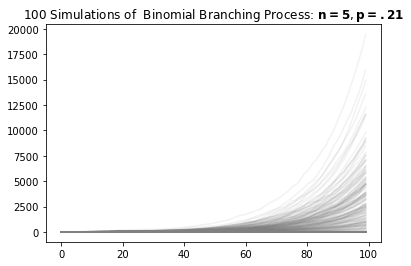

In [135]:
figure(figsize=(10, 6), dpi=80)

fun_test.loc[:,fun_test.columns != "Expected"].plot(legend=False,c="gray",alpha=.1)

## how to use a variable in the string? str.format or something
plt.title("100 Simulations of  Binomial Branching Process: $\mathbf{n=5},\mathbf{p=.21}$")

# call the branch sim function for each county and plot the fitted branch sim against the actual daily case counts
   ### - for each county, need number of new cases on day $n$, in order to find the $p$ for the branch sim call
   ### - each county will have daily case counts plot. same index for each

## one plot per county, stats to look at would be the sum of squared residuals and the RMSE of the observations by day (table for these, maybe only a few plots)

## the so what???


### lastly will be to predict into the future 
#### - the model here is a linear fit using only the expected value for the distribution based on the observed cases at day n
#### - we can use this value as the input to the simulation, and use that returned simulated value as the predictor of the next day + to see how the model performs for each county
         - another option could be a moving average of the simulations for prediction

In [119]:
#plotting function for each county

def pplot(df,county,fig):
    
    cols_to_plot = ["Expected_Sim","Expected_Theory","daily_cases"]
    
    df[df.columns.intersection(cols_to_plot)].plot()
    fig.add_subplot()
    plt.title("Fitted Simulation, Theoretical Branching Process Overlaid with\n "+county+" Daily Case Recordings")


In [186]:
## function for iterating through the counties and simulating a branching process then storing the actual spread
## with the expected counts based on the nth day

# branch_sim()
### @param: n,p for binomial distribution
### @param: county name
### @param: number of days to simulate

def county_branch(county):
    
    print("Simulating and storing for: "+county)
    num_days_to_sim = 100
    num_days_to_forecast = 30
    
    first_case = pd.Series(counties_filter[counties_filter.county==county].cases > 0)
    first_case = first_case[first_case].index[0]
    
    temp_df = counties_filter.iloc[first_case:first_case+num_days_to_sim,:]
    dates_of_sim = temp_df.date
    
    forecast_df = counties_filter.iloc[first_case+num_days_to_sim+1:first_case+num_days_to_sim+1+num_days_to_forecast,:]
    mu = temp_df.iloc[99,4]**(1/num_days_to_sim) #mu based on 100th day cases, what if i took average cases instead
    
    ## find p
    n = 5
    p = mu / n
    
    params = (n,p)
    
    county_df = branch_sim(params=params,county=county,dates=dates_of_sim,num_days_to_sim=num_days_to_sim)
    county_df["daily_cases"] = temp_df.daily_diff.values #add daily counts to end for plotting
    county_df["Expected_Theory"] = np.array([1]+[mu**n for n in range(1,num_days_to_sim)])
    county_df["Sq_Er"] = (county_df.Expected_Theory - county_df.daily_cases)**2
    county_df.index = dates_of_sim

    #pplot(county_df,county)
    
    return((county_df,forecast_df,mu))

## call for each county and produce a plot with the branching sim and the
## actual daily differences for the paper

##### need to store the outputs, and the expected value of the distribution for each.
######### will use the expected value to predict into the future
############### this number would be an anticipated case additions if no preventative measures are put into place

output_analyze = {}

for county in all_counties:
    
    # store the data frame, mu for that county
    output_analyze[county] = county_branch(county)

Simulating and storing for: Anson
Simulating and storing for: Atoka
Simulating and storing for: Bailey
Simulating and storing for: Bleckley
Simulating and storing for: Cherokee
Simulating and storing for: Crawford
Simulating and storing for: Dolores
Simulating and storing for: Edmonson
Simulating and storing for: Fairfax
Simulating and storing for: Gratiot
Simulating and storing for: Hardin
Simulating and storing for: Logan
Simulating and storing for: Los Angeles
Simulating and storing for: Mitchell
Simulating and storing for: Morris
Simulating and storing for: Ralls
Simulating and storing for: Spencer
Simulating and storing for: Upshur
Simulating and storing for: Wayne
Simulating and storing for: Wicomico


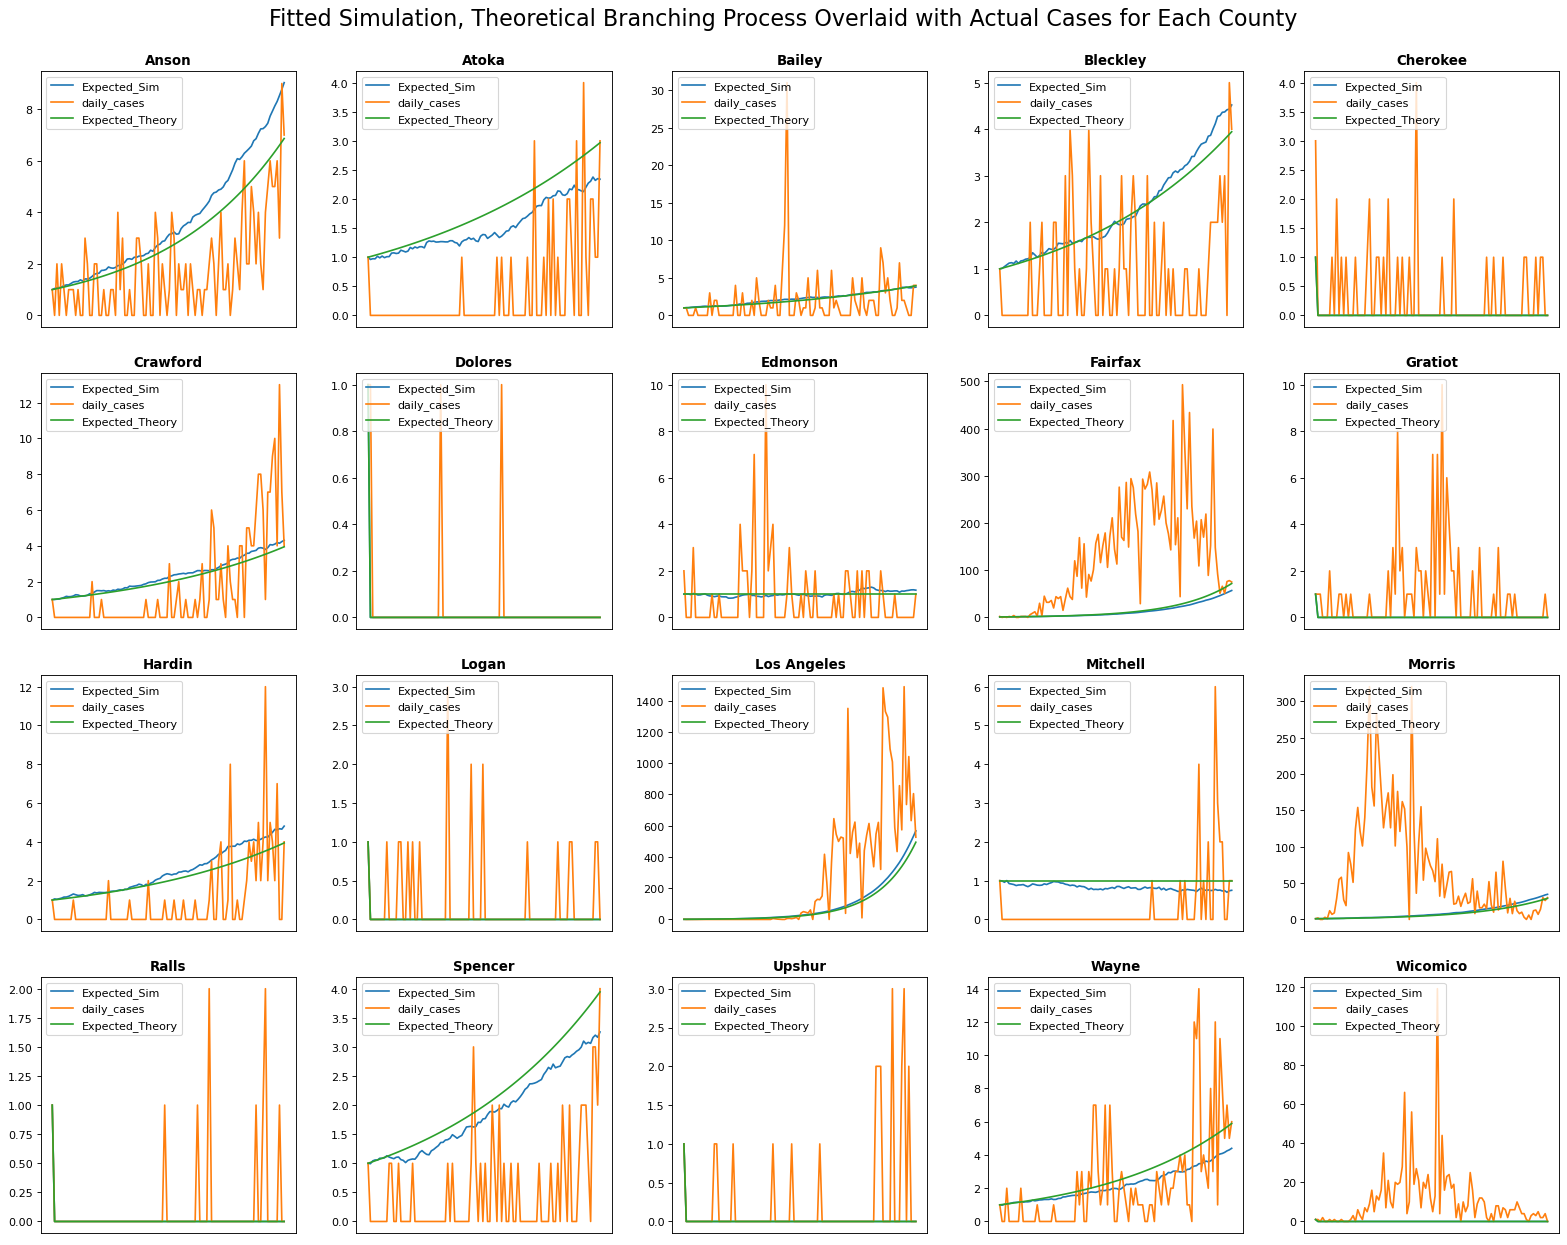

In [214]:
## calculate RMSE for training set, then try to predict n+1,n+2,n+...,n+30 days into future. 

index = 1
fig = figure(figsize=(20, 16), dpi=80)
cols_to_plot = ["Expected_Sim","Expected_Theory","daily_cases"]

for c, data in output_analyze.items():
    
    df = data[0]
    ax = fig.add_subplot(4,5,index)
    index += 1
    
    fig.suptitle("Fitted Simulation, Theoretical Branching Process Overlaid with Actual Cases for Each County",fontsize=20)
    df[df.columns.intersection(cols_to_plot)].plot(ax=ax)
    plt.title(c,fontsize="large",fontweight="bold")
    plt.legend(loc="upper left")
    plt.xticks([])
    plt.xlabel("")
    plt.tight_layout(pad=2.2)


## add RMSE for each county to the stored dictionary


## for every county, look at probability of extinction and maybe the variance at day $n$

$E[y_n]$ could be estimated by the expectation of the branching process at that generation. Using this number, we could find the $n^{th}$ root of the 100th day to find out expected propagation number... then we can just test the branching process vs. the actual spread. The daily diff is the number of children created at each generation


# some analysis on the probability of extinction for each county given the value at the 100th day
# pgf for the distribution, solve that polynomial in python

3549.8918416314364


,1,2,3,4,5,6,7,8,9,10,...,995,996,997,998,999,1000,Expected_Sim,daily_cases,Expected_Theory,squared_error
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,0,1936,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,329.778,735,384.535515,122825.355055
2020-05-01,0,2089,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,350.690,1042,409.398563,400184.577565
2020-05-02,0,2226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,374.229,632,435.869190,38467.294467
2020-05-03,0,2353,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,398.921,805,464.051338,116245.990077
2020-05-04,0,2474,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,424.433,526,494.055669,1020.440299
